RUNNING HYBRID SIMULATION


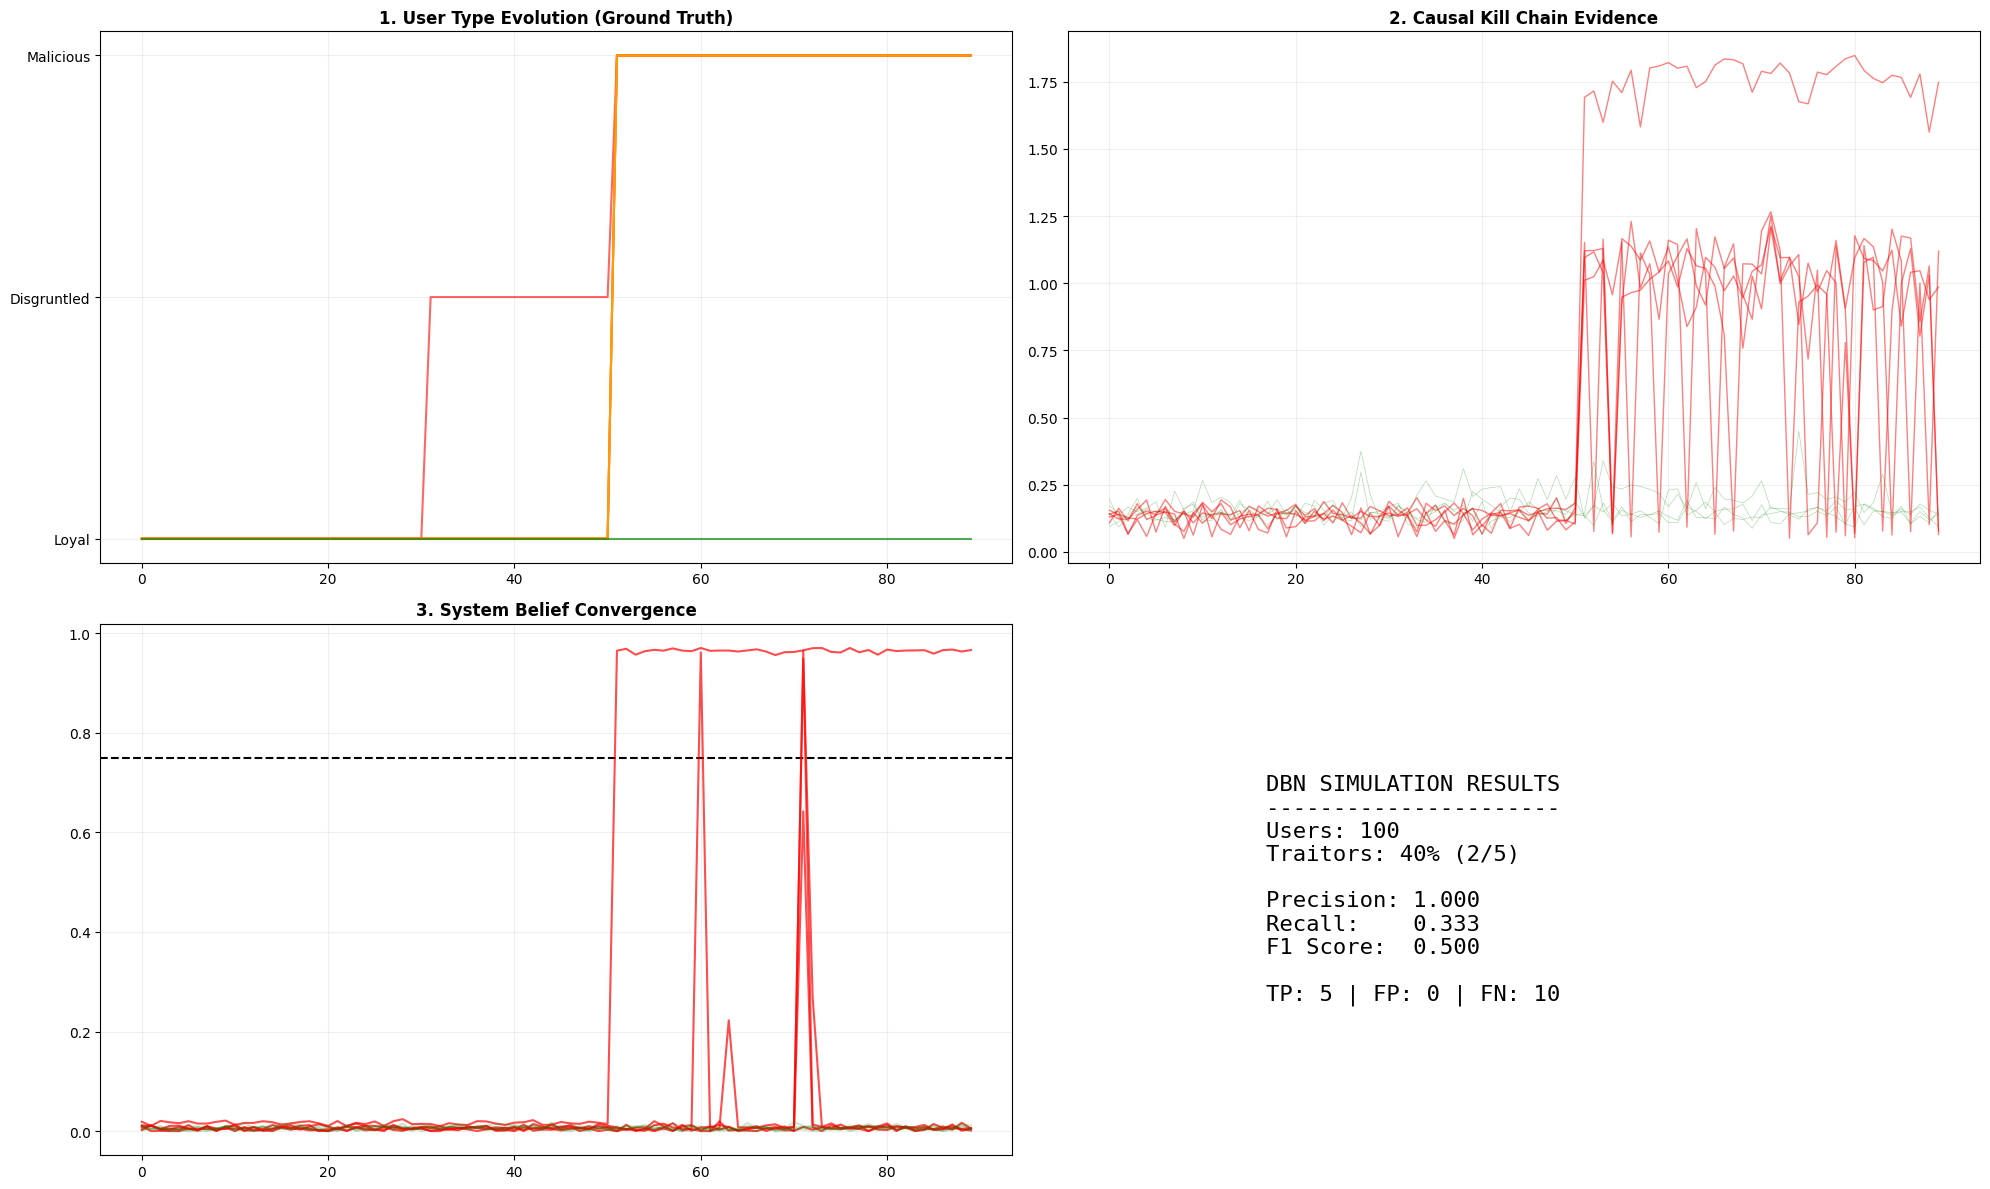

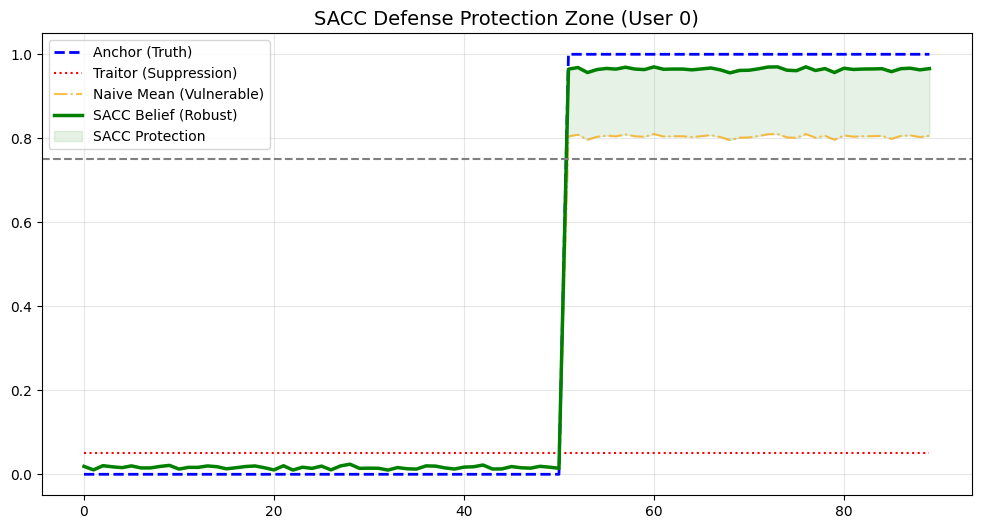


✓ Process Complete.


In [38]:
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import beta
import os
import random

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

class UserType(Enum):
    LOYAL = 0
    DISGRUNTLED = 1 
    MALICIOUS = 2

@dataclass
class ChannelMetadata:
    index: int
    name: str
    category: str
    severity: float

# ============================================================================
# 2. CAUSAL DBN ENGINE
# ============================================================================

class CausalDependencyDBN:
    def __init__(self, channels: Dict[str, ChannelMetadata]):
        self.channels = channels
        self.causal_parents = self._build_dynamic_graph()
        
        # Likelihood Parameters 
        self.params = {
            UserType.LOYAL: {'a': 2, 'b': 12},       # Mean ~0.14 (Quiet)
            UserType.DISGRUNTLED: {'a': 4, 'b': 6},  # Mean ~0.40 (Noisy)
            UserType.MALICIOUS: {'a': 10, 'b': 2}    # Mean ~0.83 (High/Suspicious)
        }

    def _build_dynamic_graph(self) -> Dict[int, List[int]]:
        parents = {meta.index: [] for meta in self.channels.values()}
        cat_indices = {cat: [] for cat in ["Access", "Reconnaissance", "Privilege", "Exfiltration"]}
        
        for meta in self.channels.values():
            if meta.category in cat_indices: cat_indices[meta.category].append(meta.index)

        # Kill Chain Dependencies
        for recon in cat_indices["Reconnaissance"]: parents[recon].extend(cat_indices["Access"])
        for priv in cat_indices["Privilege"]: 
            parents[priv].extend(cat_indices["Access"] + cat_indices["Reconnaissance"])
        for exfil in cat_indices["Exfiltration"]:
            parents[exfil].extend(cat_indices["Privilege"] + cat_indices["Reconnaissance"])
            
        return parents

    def get_conditional_params(self, idx: int, val: float, parents: List[float], u_type: UserType):
        p = self.params[u_type]
        a, b = p['a'], p['b']
        
        if not parents: return a, b
        parent_avg = np.mean(parents)
        
        # Malicious Causal Link: If parents are high, child becomes VERY high
        if u_type == UserType.MALICIOUS and parent_avg > 0.5:
            return a + 10, 1.0 
        
        # Loyal/Disgruntled: Weak correlation
        return a + (parent_avg * 0.5), b

    def compute_log_likelihood(self, signals: np.ndarray, user_type: UserType) -> float:
        log_prob = 0.0
        epsilon = 1e-9
        for name, meta in self.channels.items():
            idx = meta.index
            val = np.clip(signals[idx], 0.01, 0.99)
            p_vals = [signals[p] for p in self.causal_parents[idx]]
            
            a, b = self.get_conditional_params(idx, val, p_vals, user_type)
            log_prob += np.log(beta.pdf(val, a, b) + epsilon)
        return log_prob

    def compute_threat_score(self, signals: np.ndarray) -> float:
        score = 0.0
        weights = 0.0
        for name, meta in self.channels.items():
            val = signals[meta.index]
            w = meta.severity * (2.0 if val > 0.7 else 1.0) 
            score += val * w
            weights += meta.severity
        return score / weights if weights > 0 else 0

# ============================================================================
# 3. BYZANTINE COMMITTEE
# ============================================================================

class ByzantineCommittee:
    def __init__(self, channels, n_members=5, f_traitors=1):
        self.dbn = CausalDependencyDBN(channels)
        self.n_members = n_members
        self.f_traitors = f_traitors
        self.gamma = 0.15 # SACC Clipping Bound
        
        self.user_beliefs = {}
        self.belief_history = {}
        
        self.transitions = {
            UserType.LOYAL: {UserType.LOYAL: 0.99, UserType.DISGRUNTLED: 0.01, UserType.MALICIOUS: 0.0},
            UserType.DISGRUNTLED: {UserType.LOYAL: 0.05, UserType.DISGRUNTLED: 0.90, UserType.MALICIOUS: 0.05},
            UserType.MALICIOUS: {UserType.LOYAL: 0.0, UserType.DISGRUNTLED: 0.0, UserType.MALICIOUS: 1.0}
        }

    def initialize_user(self, uid):
        self.user_beliefs[uid] = {UserType.LOYAL: 0.9, UserType.DISGRUNTLED: 0.09, UserType.MALICIOUS: 0.01}
        self.belief_history[uid] = {"system": [], "anchor": [], "byzantine": [], "raw_mean": []}

    def _bayes_update(self, prior, signals):
        pred = {t: sum(prior[s] * self.transitions[s][t] for s in UserType) for t in UserType}
        log_likes = {t: self.dbn.compute_log_likelihood(signals, t) for t in UserType}
        max_l = max(log_likes.values())
        likes = {t: np.exp(l - max_l) for t, l in log_likes.items()}
        post_un = {t: pred[t] * likes[t] for t in UserType}
        norm = sum(post_un.values()) or 1e-9
        return {t: v/norm for t, v in post_un.items()}

    def certify(self, uid, signals):
        if uid not in self.user_beliefs: self.initialize_user(uid)
        
        # 1. Anchor (Truth)
        anchor_dist = self._bayes_update(self.user_beliefs[uid], signals)
        anchor_mal = anchor_dist[UserType.MALICIOUS]
        
        # 2. Honest Reports
        reports = [np.clip(anchor_mal + random.uniform(-0.03, 0.03), 0, 1) for _ in range(self.n_members - self.f_traitors)]
        
        # 3. Traitor Reports
        # Visualization User (0): Aggressive suppression to visualize the gap
        # Others: "Little is Enough" attack to evade clipping
        if uid == 0:
            traitor_val = 0.05
        else:
            traitor_val = max(0.0, anchor_mal - 0.25)
            
        reports.extend([traitor_val] * self.f_traitors)
        
        # 4. SACC Aggregation
        clipped = []
        for r in reports:
            diff = r - anchor_mal
            if abs(diff) > self.gamma:
                clipped.append(anchor_mal + (np.sign(diff) * self.gamma))
            else:
                clipped.append(r)
        
        robust_mal = np.mean(clipped)
        
        # Update State
        rem = 1.0 - robust_mal
        self.user_beliefs[uid] = {
            UserType.LOYAL: rem * 0.9, UserType.DISGRUNTLED: rem * 0.1, UserType.MALICIOUS: robust_mal
        }
        
        # Log History
        h = self.belief_history[uid]
        h["system"].append(robust_mal)
        h["anchor"].append(anchor_mal)
        h["byzantine"].append(traitor_val)
        h["raw_mean"].append(np.mean(reports))
        
        return robust_mal

# ============================================================================
# 4. SIMULATION LOOP (Hybrid)
# ============================================================================
class ByzantineSimulation:
    def __init__(self, policy_file):
        self.channels = self._load_policies(policy_file)
        self.committee = ByzantineCommittee(self.channels)
        self.n_channels = len(self.channels)

    def _load_policies(self, fpath):
        with open(fpath) as f: policies = json.load(f)
        temp = {}
        for p in policies:
            cn = p['signal_channel']
            if cn not in temp: 
                temp[cn] = ChannelMetadata(len(temp), cn, p.get('category', 'Activity'), p.get('severity', 0.5))
        return temp

    def _generate_signals(self, u_type, t, is_malicious, uid):
        signals = np.random.beta(2, 12, size=self.n_channels)

        if is_malicious:
            # A. VISUALIZATION USER (0)
            if uid == 0:
                if t > 50:
                    for m in self.channels.values():
                        signals[m.index] = np.random.beta(15, 2) 
                    return np.clip(signals, 0.01, 0.99)
                
            # B. OTHERS (Standard Attacker)
            else:
                if random.random() < 0.15: return np.clip(signals * 0.5, 0.01, 0.99)
                if t > 50: 
                    # FIX: Boost ALL stages of the kill chain, not just exfil
                    # This allows the DBN to see the full causal path
                    for m in self.channels.values():
                        if m.category == "Access":
                            signals[m.index] = np.random.beta(12, 4) # Suspicious Access
                        elif m.category in ["Exfiltration", "Privilege"]:
                            signals[m.index] = np.random.beta(10, 2) # High Impact
        
        elif u_type == UserType.DISGRUNTLED:
            n_spikes = random.randint(1, 3)
            indices = random.sample(range(self.n_channels), n_spikes)
            for idx in indices:
                signals[idx] = np.random.beta(4, 6)

        elif u_type == UserType.LOYAL and random.random() < 0.02:
            idx = random.randint(0, self.n_channels-1)
            signals[idx] = 0.85

        return np.clip(signals, 0.01, 0.99)

    def run(self, n_users=100, pct_mal=0.15, horizon=90):
        n_mal = int(n_users * pct_mal)
        results = {"detected": [], "false_positives": [], "undetected": [], "hist": {}}
        THRESHOLD = 0.75

        for uid in range(n_users):
            is_mal = uid < n_mal
            u_type = UserType.LOYAL
            self.committee.initialize_user(uid)
            results["hist"][uid] = {"type": [], "causal_score": []}
            detected = False

            for t in range(horizon):
                if uid == 0:
                    if t > 50: u_type = UserType.MALICIOUS
                    elif t > 30: u_type = UserType.DISGRUNTLED
                else:
                    if is_mal and t > 50: u_type = UserType.MALICIOUS
                    elif not is_mal and t > 30 and random.random() < 0.02: u_type = UserType.DISGRUNTLED
                
                results["hist"][uid]["type"].append(u_type.value)
                signals = self._generate_signals(u_type, t, is_mal, uid)
                p_mal = self.committee.certify(uid, signals)
                threat = self.committee.dbn.compute_threat_score(signals)
                
                results["hist"][uid]["causal_score"].append(threat)
                risk = (p_mal * 0.7) + (threat * 0.3)

                if risk > THRESHOLD and not detected:
                    detected = True
                    if is_mal: results["detected"].append(uid)
                    else: results["false_positives"].append(uid)
            
            if is_mal and not detected: results["undetected"].append(uid)

        return results

# ============================================================================
# 5. VISUALIZATION
# ============================================================================

class FullVisualizer:
    @staticmethod
    def plot_main_dashboard(res, committee, n_users):
        fig = plt.figure(figsize=(20, 12))
        gs = gridspec.GridSpec(2, 2)

        # Panel 1: Type Evolution
        ax1 = plt.subplot(gs[0, 0])
        ax1.set_title("1. User Type Evolution (Ground Truth)", fontweight='bold')
        ax1.set_yticks([0, 1, 2])
        ax1.set_yticklabels(['Loyal', 'Disgruntled', 'Malicious'])
        for uid in list(res["detected"][:3]) + list(res["undetected"][:3]):
            color = 'red' if uid in res["detected"] else 'orange'
            ax1.plot(res["hist"][uid]["type"], color=color, alpha=0.6)
        for uid in range(n_users - 3, n_users):
            ax1.plot(res["hist"][uid]["type"], color='green', alpha=0.3)
        ax1.grid(True, alpha=0.2)

        # Panel 2: Causal Scores
        ax2 = plt.subplot(gs[0, 1])
        ax2.set_title("2. Causal Kill Chain Evidence", fontweight='bold')
        for uid in res["hist"]:
            scores = res["hist"][uid]["causal_score"]
            if uid in res["detected"][:5]:
                ax2.plot(scores, color='red', alpha=0.5, linewidth=1)
            elif uid > n_users - 5:
                ax2.plot(scores, color='green', alpha=0.3, linewidth=0.5)
        ax2.grid(True, alpha=0.2)

        # Panel 3: Belief Convergence
        ax3 = plt.subplot(gs[1, 0])
        ax3.set_title("3. System Belief Convergence", fontweight='bold')
        ax3.axhline(0.75, color='black', linestyle='--')
        for uid in res["hist"]:
            beliefs = committee.belief_history[uid]["system"]
            if uid in res["detected"][:5]: ax3.plot(beliefs, color='red', alpha=0.7)
            elif uid in res["false_positives"][:5]: ax3.plot(beliefs, color='blue', alpha=0.6)
            elif uid > n_users - 5: ax3.plot(beliefs, color='green', alpha=0.2)
        ax3.grid(True, alpha=0.2)

        # Panel 4: Metrics
        ax4 = plt.subplot(gs[1, 1])
        ax4.axis('off')
        tp, fp = len(res["detected"]), len(res["false_positives"])
        fn = len(res["undetected"])
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        
        txt = f"""
        DBN SIMULATION RESULTS
        ----------------------
        Users: {n_users}
        Traitors: 40% (2/5)
        
        Precision: {prec:.3f}
        Recall:    {rec:.3f}
        F1 Score:  {f1:.3f} 
        
        TP: {tp} | FP: {fp} | FN: {fn}
        """
        ax4.text(0.1, 0.5, txt, fontsize=16, family='monospace', va='center')
        
        plt.tight_layout()
        plt.savefig("dbn_dashboard.png")
        plt.show()

    @staticmethod
    def plot_sacc_robustness(committee, uid_malicious):
        hist = committee.belief_history[uid_malicious]
        plt.figure(figsize=(12, 6))
        plt.plot(hist["anchor"], color='blue', linestyle='--', label='Anchor (Truth)', linewidth=2)
        plt.plot(hist["byzantine"], color='red', linestyle=':', label='Traitor (Suppression)', linewidth=1.5)
        plt.plot(hist["raw_mean"], color='orange', linestyle='-.', label='Naive Mean (Vulnerable)', alpha=0.7)
        plt.plot(hist["system"], color='green', label='SACC Belief (Robust)', linewidth=2.5)
        
        plt.title(f"SACC Defense Protection Zone (User {uid_malicious})", fontsize=14)
        plt.axhline(0.75, color='grey', linestyle='--')
        plt.fill_between(range(len(hist["system"])), hist["raw_mean"], hist["system"], color='green', alpha=0.1, label='SACC Protection')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig("sacc_robustness.png")
        plt.show()

# ============================================================================
# MAIN
# ============================================================================
if __name__ == "__main__":
    if not os.path.exists("policies.json"):
        with open("policies.json", "w") as f:
            json.dump([
                {"signal_channel": "s_logon", "category": "Access", "severity": 0.6},
                {"signal_channel": "s_file", "category": "Reconnaissance", "severity": 0.7},
                {"signal_channel": "s_role", "category": "Privilege", "severity": 0.9},
                {"signal_channel": "s_exfil", "category": "Exfiltration", "severity": 0.8}
            ], f)

    print("="*60)
    print("RUNNING HYBRID SIMULATION")
    print("="*60)
    
    sim = ByzantineSimulation("policies.json")
    results = sim.run(n_users=100, pct_mal=0.15, horizon=90)
    
    FullVisualizer.plot_main_dashboard(results, sim.committee, 100)
    
    # Plot SACC Robustness for User 0 (Guaranteed Attacker)
    FullVisualizer.plot_sacc_robustness(sim.committee, 0)
        
    print("\n✓ Process Complete.")